In [4]:
import os
import glob
import torch.utils.data as td
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)

from dataset.fbms_dataset import fbms_dataset
from models.motion_stn import motion_stn,motion_net
from models.motionseg.motion_fcn import motion_fcn,motion_fcn_stn
from dataset.dataset_generalize import image_normalizations
from utils.torch_tools import get_ckpt_path,load_ckpt
from utils.disc_tools import show_images,show_tensor_list

In [6]:
config={}
config['dataset']='FBMS'
config['net_name']='motion_fcn'
config['train_path']='/media/sdb/CVDataset/ObjectSegmentation/FBMS/Trainingset'
config['val_path']='/media/sdb/CVDataset/ObjectSegmentation/FBMS/Testset'
config['frame_gap']=5
config['log_dir']=os.path.expanduser('~/tmp/logs/motion')
config['epoch']=30
config['init_lr']=1e-4
config['stn_loss_weight']=1.0
config['motion_loss_weight']=1.0
config['pose_mask_reg']=1.0
config['stn_object']='images'
config['note']='wo_stn'
config['save_model']=True
config['backbone_name']='vgg16'
config['upsample_layer']=3

normer=image_normalizations(ways='-1,1')
dataset_loaders={}
for split in ['train','val']:
    xxx_dataset=fbms_dataset(config,split,normalizations=normer)
    xxx_loader=td.DataLoader(dataset=xxx_dataset,batch_size=4,shuffle=True,drop_last=False,num_workers=2)
    dataset_loaders[split]=xxx_loader

if config['net_name'] in ['motion_stn','motion_net']:
    model=globals()[config['net_name']]() 
else:
    model=globals()[config['net_name']](config)
# support for cpu/gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

log_dir = os.path.join(config['log_dir'], config['net_name'],
                       config['dataset'], config['note'])
checkpoint_path = get_ckpt_path(log_dir)
model=load_ckpt(model,checkpoint_path)


use none layer******************************
no checkpoint file given, auto find /home/yzbx/tmp/logs/motion/motion_fcn/FBMS/wo_stn/2019-01-17___22-08-52/model-last-30.pkl


0 -0.24739303 0.43195522 1.0 -1.0


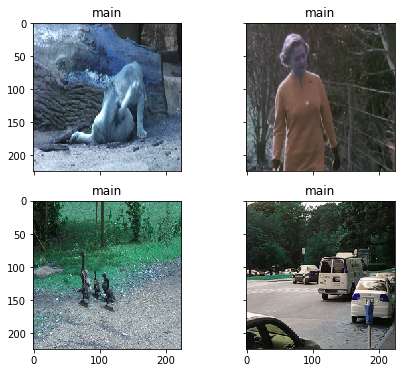

1 -0.23691808 0.4360045 1.0 -1.0


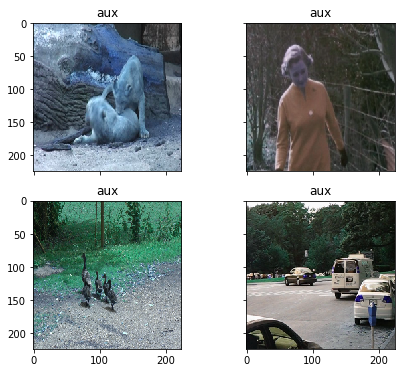

0 0.1420001594387755 0.3490503031915856 1 0


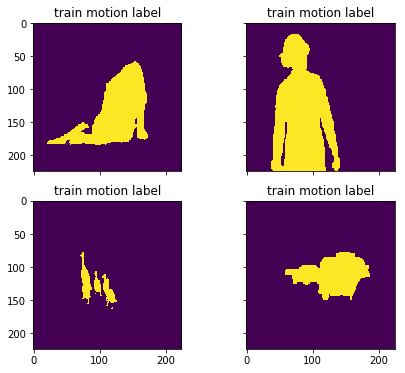

0 0.1191601 0.21708602 0.97322106 1.4681508e-07


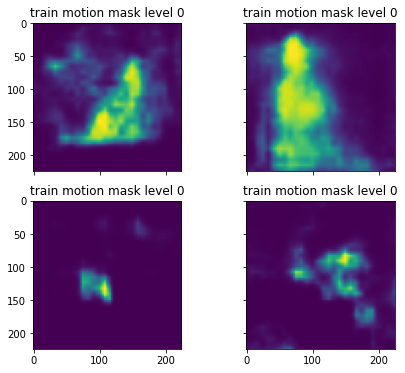

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f50489fbef0>>
Traceback (most recent call last):
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/yzbx/bin/minicond

0 -0.19123831 0.46615708 1.0 -1.0


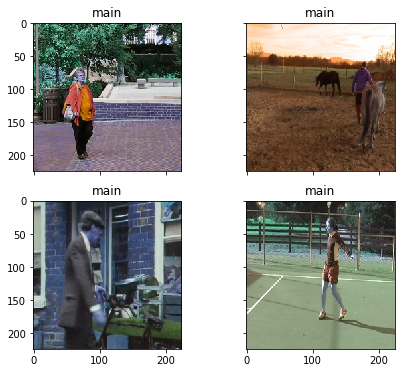

1 -0.19719723 0.46394265 1.0 -1.0


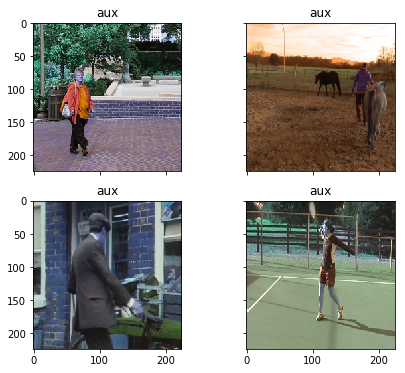

0 0.10476124043367346 0.3062455272105562 1 0


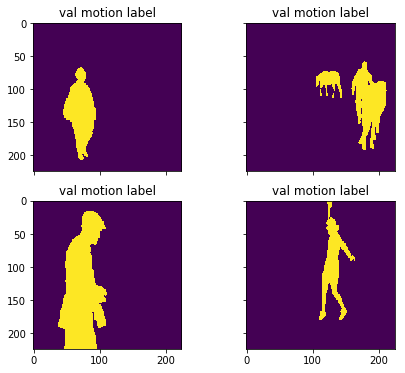

0 0.13064066 0.20965481 0.9872728 4.258433e-09


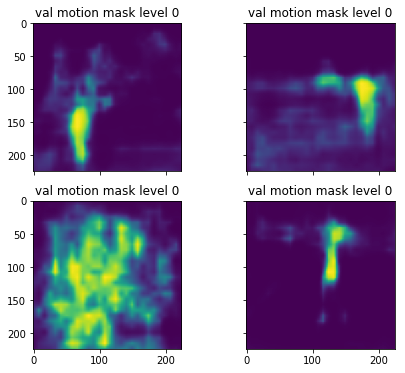

In [8]:
model.eval()
for split in ['train','val']:
    for frames,gt in dataset_loaders[split]:
        images = [torch.autograd.Variable(img.to(device).float()) for img in frames]
        labels=torch.autograd.Variable(gt.to(device).long())
        outputs=model.forward(images)
        
        show_tensor_list(images,['main','aux'],normer)
        show_tensor_list([gt],[split+' motion label'])
        show_tensor_list(outputs['masks'],[split+' motion mask level '+str(idx) for idx,t in enumerate(outputs['masks'])])
        
        break